In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [136]:
norm = 2000
#Simulation parameters
richNeighbourhoods = 10
poorNeighbourhoods = 15
richPeople = 1
poorPeople = 1
richVisitRich = 1
richVisitPoor = 1
poorVisitPoor = 1
poorVisitRich = 1
richSpend = 200
poorSpend = 50
radiusPenalty = 2
locationPenalty = 2
iterations = 10**4

totalNeighbourhoods = richNeighbourhoods + poorNeighbourhoods
totalPopulation = richPeople + poorPeople
richDistribution = np.append(np.full(richNeighbourhoods,richVisitRich),np.full(poorNeighbourhoods,richVisitPoor))
poorDistribution = np.append(np.full(richNeighbourhoods,poorVisitRich),np.full(poorNeighbourhoods,poorVisitPoor))
#Annealing parameters 


In [106]:
#np.random.seed(1)
def generateNeighbourhoods(nNeighbourhoods):
    x = np.random.randint(0,norm,nNeighbourhoods)
    y = np.random.randint(0,norm,nNeighbourhoods)
    return x,y

xp,yp = generateNeighbourhoods(poorNeighbourhoods)
xr,yr = generateNeighbourhoods(richNeighbourhoods)

x = np.append(xr,xp)
y = np.append(yr,yp)

In [119]:
def connect(x,y,p1,p2,color='k'):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2],[y1,y2],color+'-')

def intersects(x,y,p1,p2,cx,cy,cr):
    ax, bx = x[p1], x[p2]
    ay, by = y[p1], y[p2]
    ax -= cx;
    ay -= cy;
    bx -= cx;
    by -= cy;
    c = ax**2 + ay**2 - cr**2;
    b = 2*(ax*(bx - ax) + ay*(by - ay));
    a = (bx - ax)**2 + (by - ay)**2;
    disc = b**2 - 4*a*c;
    if(disc <= 0):
        return False;
    sqrtdisc = math.sqrt(disc);
    t1 = (-b + sqrtdisc)/(2*a);
    t2 = (-b - sqrtdisc)/(2*a);
    return ((0 < t1 and t1 < 1) or (0 < t2 and t2 < 1))

def drawRoutes(x,y,cx,cy,cr):
    for i in range(0,len(x)):
        for j in range(i,len(x)):
            if(intersects(x,y,i,j,cx,cy,cr)):
                connect(x,y,i,j,color='r')
            else:
                connect(x,y,i,j,color='k')
                
def plot(cx,cy,cr):
    plt.figure(figsize=(10, 10))
    ax = plt.axes()
    ax.set_xlim(0.0,norm), ax.set_xticks([])
    ax.set_ylim(0.0, norm), ax.set_yticks([])
    drawRoutes(x,y,cx,cy,cr)
    cir = plt.Circle((cx,cy),radius=cr, color='green')
    ax = plt.gca()
    ax.add_artist(cir)
    plt.plot(xr,yr,'ro',markersize=20)
    plt.plot(xp,yp,'bo',markersize=20)
    plt.show()

def visibleRoutes(x,y,cx,cy,cr,visibleRoutes):
    for i in range(0,len(x)):
        for j in range(i,len(x)):
            if(intersects(x,y,i,j,cx,cy,cr)):
                visibleRoutes.add((i,j));
                visibleRoutes.add((j,i));
                
                
def dist(x, y):
    return math.sqrt((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2)

def calcPrice(x,y,cx,cy,cr,richNeighbourhoods):
    price = 0
    for i in zip(x[:richNeighbourhoods],y[:richNeighbourhoods]):
        price += (math.sqrt(2*norm**2) - dist(i,(cx,cy)))
    return price*locationPenalty + radiusPenalty*cr**2
                
def MetropolisHastings(neighbours,direction_probability,stationary_distribution):
    states = len(neighbours.keys())
    MH_mat = np.zeros((states,states))
    proposal_mat = np.zeros((states,states))

    for state,adjacent in zip(neighbours.keys(),neighbours.values()):
        for direction in range(len(neighbours.keys())):
            proposal_mat[state,adjacent[direction]] += direction_probability[direction]

    for state,adjacent in zip(neighbours.keys(),neighbours.values()):
        accept_probability = 0.0 #the probability to move to any of the neighbouring states
        for direction in range(len(neighbours.keys())):
            if(adjacent[direction]!=state):
                acceptance_ratio = min(1, \
                    (stationary_distribution[adjacent[direction]]*proposal_mat[adjacent[direction],state])/ \
                    (stationary_distribution[state]*proposal_mat[state,adjacent[direction]]))
                transition_probability = direction_probability[direction]*acceptance_ratio
                accept_probability += transition_probability
                MH_mat[state,adjacent[direction]] = transition_probability
        MH_mat[state,state] = 1-accept_probability
    return MH_mat

def generateMarkovMat(stationary_distribution):
    neighbours = {x:list(range(totalNeighbourhoods)) for x in range(totalNeighbourhoods)}
    direction_probability = np.full(totalNeighbourhoods,1/(totalNeighbourhoods))
    return MetropolisHastings(neighbours,direction_probability,stationary_distribution)
    
richMM = generateMarkovMat(richDistribution)
poorMM = generateMarkovMat(poorDistribution)

#cumulative sums for determining next states
richCS = np.cumsum(richMM,axis=1)
poorCS = np.cumsum(poorMM,axis=1)

In [120]:
#can probably use 2 agents - one rich and one poor and run the simulation for longer

def step(state,cumsumArray):
    return np.argmax(cumsumArray[state] > np.random.uniform(0,1))

def stepAll(states, markovMat):
     return np.fromiter((step(x,markovMat) for x in states),x.dtype)

def simulate(cx,cy,cr):
    richVisits = 0
    poorVisits = 0
    agent_rich_state = np.random.randint(0,richNeighbourhoods,richPeople)
    agent_poor_state = np.random.randint(richNeighbourhoods,poorNeighbourhoods,poorPeople)
    visibileRoutes = set()
    visibleRoutes(x,y,cx,cy,cr,visibileRoutes)
    for i in range(iterations):
        agent_rich_state_new = stepAll(agent_rich_state,richCS)#richCS)
        agent_poor_state_new = stepAll(agent_poor_state,poorCS)#poorCS)
        for i in zip(agent_rich_state,agent_rich_state_new):
            if (i in visibileRoutes and np.random.uniform(0,1) > 0.5):
                richVisits += 1
        for i in zip(agent_poor_state,agent_poor_state_new):
            if (i in visibileRoutes and np.random.uniform(0,1) > 0.5):
                poorVisits += 1
        agent_rich_state = agent_rich_state_new
        agent_poor_state = agent_poor_state_new
    return richVisits, poorVisits

49136.843244846496


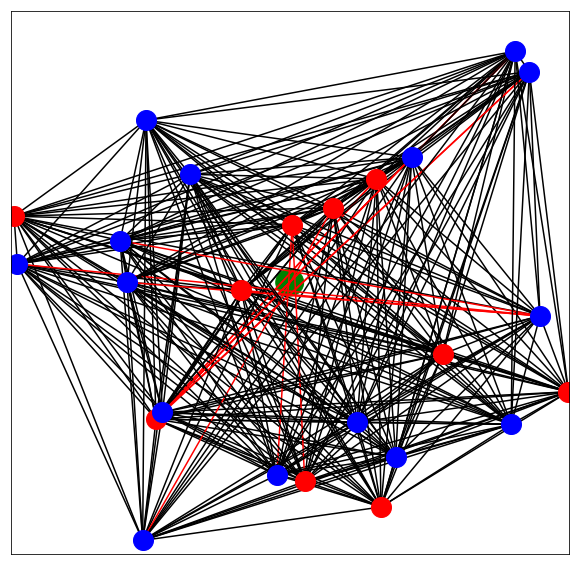

In [142]:
simulate(norm/2,norm/2,50)
print(calcPrice(x,y,norm/2,norm/2,50,richNeighbourhoods))
plot(norm/2,norm/2,50)

In [141]:

#plt.savefig('asdf.png')

In [37]:
#annealing